In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle
import matplotlib.gridspec as gridspec

<h2 style="font-size:28px; font-weight:bold;">Preparing Data</h2>

In [2]:
file_path1 = 'SSTs.nc'
file_path2 = 'TCs.nc'
  
                                  
ds1 = xr.open_dataset(file_path1)
ds2 = xr.open_dataset(file_path2)

/Users/varinradia/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [3]:
ds_grouped = ds1.groupby('time.year').mean(dim='time')                                   #Obtained Yearly Meaned Data
tropical_data = ds_grouped.sel(latitude=slice(23.5, -23.5), longitude=slice(0, 360))    #Extracted Data For the Tropics

In [4]:
with open("storms_by_year.pk", "rb") as fin:  
 storms = pickle.load(fin)

<h2 style="font-size:28px; font-weight:bold;">Exctracting lat and lon data for each storm that were sorted by year</h2>

In [5]:
# Initialize a dictionary to store storm information with latitudes and longitudes
storm_info = {}

# Iterate over the years in the storms dictionary
for year, storm_ids_year in storms.items():
    # Initialize a dictionary to store storm information for the current year
    storm_info_year = {}
    # Iterate over the storm IDs for the current year
    for storm_id in storm_ids_year:
        # Find the storm data for the current storm ID
        storm_data = ds2.sel(storm=storm_id)
        # Extract latitude and longitude values
        latitudes = storm_data['lat'].values
        longitudes = storm_data['lon'].values
        # Store latitude and longitude values in the storm_info_year dictionary
        storm_info_year[storm_id] = {'lat': latitudes, 'lon': longitudes}
    # Store storm information for the current year in the storm_info dictionary
    storm_info[year] = storm_info_year

<h2 style="font-size:28px; font-weight:bold;">Analyzing the Relationship Between SST and Tropical Cyclone Genesis Across 5°x5° grid Boxes</h2>

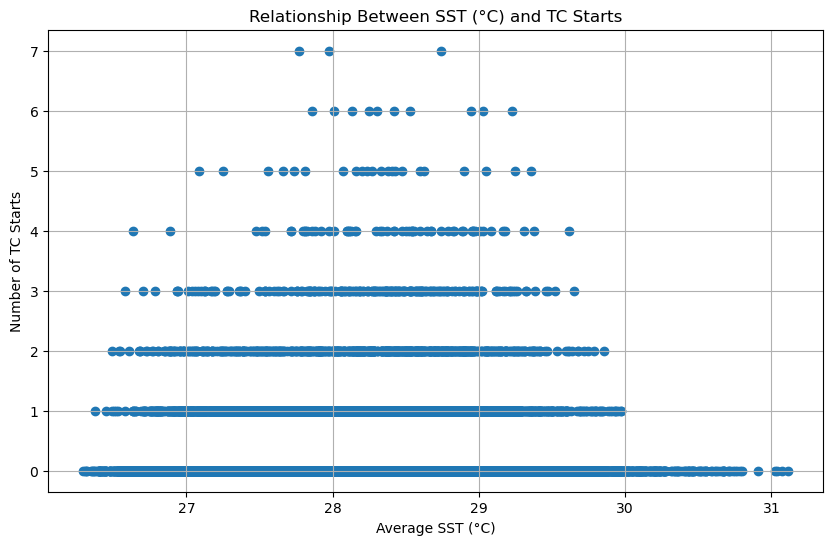

In [8]:
# Defining latitude and longitude edges for creating grid boxes
lat_edges = np.arange(-20, 21, 5)  
lon_edges = np.arange(0, 360, 5)

result = {}  # Initializing a dictionary to store the results

# Iterating over each year in the tropical data
for year in tropical_data['year'].values:
    # Selecting SST data for the current year
    sst_data = tropical_data.sel(year=year)['sst']
    # Calculating the mean SST across all latitudes and longitudes for the year, skipping NaN values
    tropical_mean_sst = sst_data.mean(dim=['latitude', 'longitude'], skipna=True).item()

    # Iterating over each grid box defined by latitude and longitude edges
    for lat_start, lat_end in zip(lat_edges[:-1], lat_edges[1:]):
        for lon_start, lon_end in zip(lon_edges[:-1], lon_edges[1:]):
            # Selecting data for the current grid box
            grid_box_data = sst_data.sel(latitude=slice(lat_end, lat_start), longitude=slice(lon_start, lon_end))
            
            # Checking if the grid box has data
            if grid_box_data.size > 0:
                # Calculating the mean SST for the current grid box, skipping NaN values
                grid_box_mean_sst = grid_box_data.mean(dim=['latitude', 'longitude'], skipna=True).item()
                
                # Checking if the grid box mean SST is greater than the tropical mean SST
                if grid_box_mean_sst > tropical_mean_sst:
                    tc_starts = 0  # Initializing the counter for tropical cyclones starting in this grid box
                    # Checking if the current year has associated storm information
                    if year in storm_info:
                        # Iterating over storms for the current year
                        for storm_data in storm_info[year].values():
                            storm_lat = storm_data['lat'][0]  # Getting the starting latitude of the storm
                            storm_lon = storm_data['lon'][0]  # Getting the starting longitude of the storm
                            # Checking if the storm starts within the current grid box
                            if lat_start <= storm_lat <= lat_end and lon_start <= (storm_lon + 360) % 360 <= lon_end:
                                tc_starts += 1  # Incrementing the counter for TC starts
                    
                    # Storing the results for the current year and grid box
                    if year not in result:
                        result[year] = []
                    result[year].append({
                        'gridbox': f'{lat_start}-{lat_end}, {lon_start}-{lon_end}',
                        'avg_sst': grid_box_mean_sst,
                        'TCs_started': tc_starts,
                        'year': year
                    })
            else:
                # Printing a message if a grid box is empty
                print(f"Grid box {lat_start}-{lat_end}, {lon_start}-{lon_end} is empty.")

# Preparing lists for plotting
ssts = []  # List for storing SSTs converted to Celsius
counts = []  # List for storing the number of TC starts
for y in result:
    for item in result[y]:
        ssts.append(item['avg_sst'] - 273.15)  # Converting Kelvin to Celsius for SST
        counts.append(item['TCs_started'])  # Adding the number of TCs that started in the grid box

# Creating a scatter plot of SST vs. TC starts
plt.figure(figsize=(10, 6))  
plt.scatter(ssts, counts)  
plt.title('Relationship Between SST (°C) and TC Starts') 
plt.xlabel('Average SST (°C)')  
plt.ylabel('Number of TC Starts')  
plt.grid(True)  
plt.show()


<h2 style="font-size:24px; font-weight:bold;">Plot examination</h2>

<div style="font-size:18px;">
<p>The plot shows a general trend where higher SSTs correlate with more frequent tropical cyclone formation, especially evident in the 27-29°C range. Despite some variability, the data suggest that SST is a significant factor in cyclone genesis, with fewer cyclones forming in cooler waters and warmer waters but with some outliers present on both sides.
</p>
</div>

<h2 style="font-size:28px; font-weight:bold;">Analyzing TC Genesis Frequency Across SST Bins</h2>

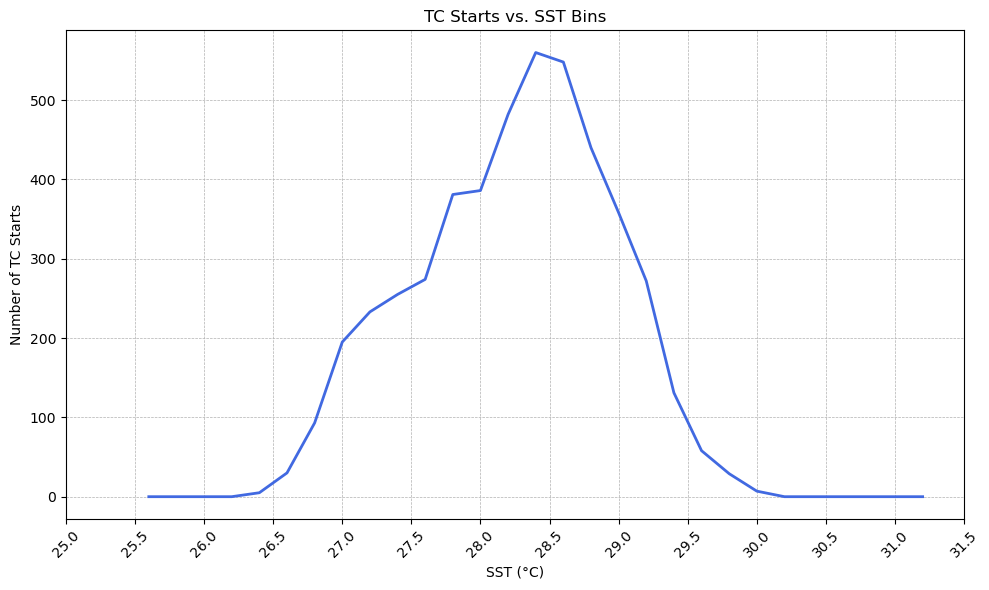

In [9]:
# Defining SST bins from 26°C to 32°C with 0.5°C increments, converting to Kelvin
sst_bins = np.arange(25.5, 31.5, 0.2) + 273.15
# Calculating midpoints of SST bins for plotting, converting back to Celsius
sst_midpoints = (sst_bins[:-1] + sst_bins[1:]) / 2 - 273.15  

# Initializing a list to hold the sum of TC starts for each SST bin
tc_starts_per_bin = np.zeros(len(sst_midpoints))

# Processing data for each year
for year, items in result.items():
    for item in items:
        avg_sst = item['avg_sst']  # The average SST is in Kelvin
        tc_starts = item['TCs_started']
        
        # Finding the bin index for the current avg_sst
        bin_index = np.digitize(avg_sst, sst_bins) - 1  
        # Adding TC starts to the corresponding SST bin, if within range
        if 0 <= bin_index < len(tc_starts_per_bin):
            tc_starts_per_bin[bin_index] += tc_starts

# Preparing arrays for plotting
sst_midpoints_array = np.array(sst_midpoints)
tc_starts_per_bin_array = np.array(tc_starts_per_bin)

# Customizing tick labels for SST in Celsius
custom_ticks = np.arange(25, 31.6, 0.5)
custom_labels = [f"{tick:.1f}" for tick in custom_ticks]

# Plotting TC starts vs. SST bins
plt.figure(figsize=(10, 6))
plt.plot(sst_midpoints_array, tc_starts_per_bin_array, color='royalblue', linewidth=2, markersize=6)
plt.title('TC Starts vs. SST Bins')
plt.xlabel('SST (°C)')
plt.ylabel('Number of TC Starts')
plt.xticks(custom_ticks, custom_labels, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjusting the layout for a better fit
plt.show()


<h2 style="font-size:24px; font-weight:bold;">Plot examination</h2>

<div style="font-size:18px;">
<p>The plot presents a pronounced peak in the number of TCs starts within the SST range of 27-29°C, reinforcing the concept that there's an optimal SST window for cyclone genesis. As SSTs rise above 26°C, TC starts increase sharply, reach a maximum in the 27-29°C range, and then decline significantly beyond this range. The drop-off in TC starts at higher SSTs may imply other environmental factors come into play that inhibit cyclone formation despite the availability of warm waters.
</p>
</div>